# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [1]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    r = requests.get(url)
    
    # Raise an exception for bad status codes
    r.raise_for_status()
    
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    
    print(f"Dataset successfully downloaded and saved as {filename}")
    return filename

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [2]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

Dataset successfully downloaded and saved as cifar.tar.gz


'cifar.tar.gz'

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [3]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

/tmp/ipykernel_454/4281747999.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [4]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [5]:
# Feel free to explore the datasets

dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [6]:
# Check the shape and type of training data
print("Training data shape:", dataset_train[b'data'].shape)
print("Number of training samples:", len(dataset_train[b'fine_labels']))

# Look at the metadata
print("Fine label names:", dataset_meta[b'fine_label_names'][:10])  # First 10 classes
print("Coarse label names:", dataset_meta[b'coarse_label_names'])

# Check test data structure
print("Test data keys:", dataset_test.keys())

Training data shape: (50000, 3072)
Number of training samples: 50000
Fine label names: [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle']
Coarse label names: [b'aquatic_mammals', b'fish', b'flowers', b'food_containers', b'fruit_and_vegetables', b'household_electrical_devices', b'household_furniture', b'insects', b'large_carnivores', b'large_man-made_outdoor_things', b'large_natural_outdoor_scenes', b'large_omnivores_and_herbivores', b'medium_mammals', b'non-insect_invertebrates', b'people', b'reptiles', b'small_mammals', b'trees', b'vehicles_1', b'vehicles_2']
Test data keys: dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [7]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [8]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [9]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

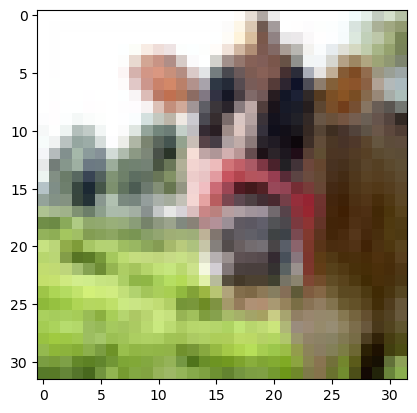

In [10]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [11]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [12]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [13]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [14]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [15]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [16]:
import pandas as pd
import numpy as np

# Get all fine label names from metadata
fine_labels = dataset_meta[b'fine_label_names']

# Find the label numbers for Bicycle and Motorcycle
bicycle_label = None
motorcycle_label = None

# Search through all labels to find bicycle and motorcycle
for i, label in enumerate(fine_labels):
    label_str = label.decode('utf-8').lower()  # Convert bytes to string and lowercase
    if 'bicycle' in label_str:
        bicycle_label = i
        print(f"Bicycle label number: {i}, Label name: {label}")
    elif 'motorcycle' in label_str:
        motorcycle_label = i
        print(f"Motorcycle label number: {i}, Label name: {label}")

# Alternative approach: Create a DataFrame for easier searching
labels_df = pd.DataFrame({
    'label_num': range(len(fine_labels)),
    'label_name': [label.decode('utf-8') for label in fine_labels]
})

print("\nUsing DataFrame search:")
bicycle_rows = labels_df[labels_df['label_name'].str.contains('bicycle', case=False)]
motorcycle_rows = labels_df[labels_df['label_name'].str.contains('motorcycle', case=False)]

print("Bicycle matches:")
print(bicycle_rows)
print("\nMotorcycle matches:")
print(motorcycle_rows)

# Get the actual label numbers
if not bicycle_rows.empty:
    bicycle_label = bicycle_rows.iloc[0]['label_num']
if not motorcycle_rows.empty:
    motorcycle_label = motorcycle_rows.iloc[0]['label_num']

print(f"\nFinal results:")
print(f"Bicycle label number: {bicycle_label}")
print(f"Motorcycle label number: {motorcycle_label}")

# Count how many samples we have for each class in training data
if bicycle_label is not None:
    bicycle_count = np.sum(np.array(dataset_train[b'fine_labels']) == bicycle_label)
    print(f"Number of bicycle images in training set: {bicycle_count}")

if motorcycle_label is not None:
    motorcycle_count = np.sum(np.array(dataset_train[b'fine_labels']) == motorcycle_label)
    print(f"Number of motorcycle images in training set: {motorcycle_count}")

# Optional: Show some examples
if bicycle_label is not None:
    bicycle_indices = np.where(np.array(dataset_train[b'fine_labels']) == bicycle_label)[0]
    print(f"First few bicycle image indices: {bicycle_indices[:5]}")

if motorcycle_label is not None:
    motorcycle_indices = np.where(np.array(dataset_train[b'fine_labels']) == motorcycle_label)[0]
    print(f"First few motorcycle image indices: {motorcycle_indices[:5]}")


Bicycle label number: 8, Label name: b'bicycle'
Motorcycle label number: 48, Label name: b'motorcycle'

Using DataFrame search:
Bicycle matches:
   label_num label_name
8          8    bicycle

Motorcycle matches:
    label_num  label_name
48         48  motorcycle

Final results:
Bicycle label number: 8
Motorcycle label number: 48
Number of bicycle images in training set: 500
Number of motorcycle images in training set: 500
First few bicycle image indices: [ 16  30 130 219 298]
First few motorcycle image indices: [152 195 251 252 370]


Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [17]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train['labels'].isin([8, 48])]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test['labels'].isin([8, 48])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

In [18]:
# Optional: Print summary statistics
print("Training set after filtering:")
print(f"Total samples: {len(df_train)}")
print(f"Label distribution:\n{df_train['labels'].value_counts().sort_index()}")

print("\nTest set after filtering:")
print(f"Total samples: {len(df_test)}")
print(f"Label distribution:\n{df_test['labels'].value_counts().sort_index()}")

# Reset index after filtering (optional but recommended)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Training set after filtering:
Total samples: 1000
Label distribution:
labels
8     500
48    500
Name: count, dtype: int64

Test set after filtering:
Total samples: 200
Label distribution:
labels
8     100
48    100
Name: count, dtype: int64


Now that the data is filtered for just our classes, we can save all our images.

In [19]:
!mkdir ./train
!mkdir ./test

mkdir: cannot create directory ‘./train’: File exists
mkdir: cannot create directory ‘./test’: File exists


In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

def save_images(row_data, filename, directory):
    """
    Save a single image from CIFAR-100 dataset
    
    Args:
        row_data: The flattened image data from dataset
        filename: The filename to save as
        directory: The directory to save in ('train' or 'test')
    """
    # Grab the image data in row-major form
    img = row_data
    
    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
        img[0:1024].reshape(32,32),      # Red channel
        img[1024:2048].reshape(32,32),   # Green channel
        img[2048:].reshape(32,32)        # Blue channel
    ))
    
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Save the image
    plt.imsave(os.path.join(directory, filename), target)
    
    # Return any signal data you want for debugging
    return f"Saved {filename} to {directory}"

# Create directories
os.makedirs('./train', exist_ok=True)
os.makedirs('./test', exist_ok=True)

# Save ALL training images
print("Saving training images...")
for idx, row in df_train.iterrows():
    original_row_idx = row['row']  # Get the original row index
    img_data = dataset_train[b'data'][original_row_idx]  # Get image data
    filename = row['filenames']  # Get filename
    
    result = save_images(img_data, filename, './train')
    if idx % 50 == 0:  # Print progress every 50 images
        print(f"Progress: {idx+1}/{len(df_train)} - {result}")

print(f"Completed saving {len(df_train)} training images")

# Save ALL test images
print("\nSaving test images...")
for idx, row in df_test.iterrows():
    original_row_idx = row['row']  # Get the original row index
    img_data = dataset_test[b'data'][original_row_idx]  # Get image data
    filename = row['filenames']  # Get filename
    
    result = save_images(img_data, filename, './test')
    if idx % 20 == 0:  # Print progress every 20 images
        print(f"Progress: {idx+1}/{len(df_test)} - {result}")

print(f"Completed saving {len(df_test)} test images")

# Print summary
print(f"\nSummary:")
print(f"Training images saved: {len(df_train)}")
print(f"Test images saved: {len(df_test)}")
print(f"Total images saved: {len(df_train) + len(df_test)}")

# Verify directories were created and populated
train_files = len(os.listdir('./train')) if os.path.exists('./train') else 0
test_files = len(os.listdir('./test')) if os.path.exists('./test') else 0
print(f"Files in ./train directory: {train_files}")
print(f"Files in ./test directory: {test_files}")

Saving training images...
Progress: 1/1000 - Saved bike_s_000682.png to ./train
Progress: 51/1000 - Saved motorcycle_s_001180.png to ./train
Progress: 101/1000 - Saved cycle_s_002053.png to ./train
Progress: 151/1000 - Saved bicycle_s_001693.png to ./train
Progress: 201/1000 - Saved cycle_s_002779.png to ./train
Progress: 251/1000 - Saved moped_s_000168.png to ./train
Progress: 301/1000 - Saved motorcycle_s_000451.png to ./train
Progress: 351/1000 - Saved motorcycle_s_001182.png to ./train
Progress: 401/1000 - Saved bike_s_000593.png to ./train
Progress: 451/1000 - Saved bicycle_s_000043.png to ./train
Progress: 501/1000 - Saved motorcycle_s_000003.png to ./train
Progress: 551/1000 - Saved safety_bicycle_s_000789.png to ./train
Progress: 601/1000 - Saved motorcycle_s_001878.png to ./train
Progress: 651/1000 - Saved bicycle_s_000243.png to ./train
Progress: 701/1000 - Saved moped_s_000119.png to ./train
Progress: 751/1000 - Saved motorcycle_s_001439.png to ./train
Progress: 801/1000 - S

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [21]:
import sagemaker

# Get the SageMaker session
sagemaker_session = sagemaker.Session()

# Get the default S3 bucket for SageMaker
bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

# Get the current AWS region
region = sagemaker_session.boto_region_name
print("AWS Region: {}".format(region))

# Get the SageMaker execution role
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

# Optional: Print additional useful information
print("\nAdditional Information:")
print("Account ID: {}".format(sagemaker_session.account_id()))
print("Session region: {}".format(sagemaker_session.boto_session.region_name))


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Default Bucket: sagemaker-us-east-1-761018893391
AWS Region: us-east-1
RoleArn: arn:aws:iam::761018893391:role/service-role/AmazonSageMaker-ExecutionRole-20250612T101289

Additional Information:
Account ID: 761018893391
Session region: us-east-1


With this data we can easily sync your data up into S3!

In [22]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-761018893391/train/bicycle_s_000017.png
upload: train/bicycle_s_000124.png to s3://sagemaker-us-east-1-761018893391/train/bicycle_s_000124.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-761018893391/train/bicycle_s_000038.png
upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-761018893391/train/bicycle_s_000021.png
upload: train/bicycle_s_000043.png to s3://sagemaker-us-east-1-761018893391/train/bicycle_s_000043.png
upload: train/bicycle_s_000035.png to s3://sagemaker-us-east-1-761018893391/train/bicycle_s_000035.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-east-1-761018893391/train/bicycle_s_000039.png
upload: train/bicycle_s_000051.png to s3://sagemaker-us-east-1-761018893391/train/bicycle_s_000051.png
upload: train/bicycle_s_000071.png to s3://sagemaker-us-east-1-761018893391/train/bicycle_s_000071.png
upload: train/bicycle_s_000099.png to s3://sagemaker-us-east-1-7610188933

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [23]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [24]:
from sagemaker import image_uris
import boto3
# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [25]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = image_uris.retrieve(
    framework='image-classification',
    region=region
)
s3_output_location = f"s3://{bucket}/models/image_model"

In [26]:
print("Algorithm Image URI: {}".format(algo_image))
print("Model Output Location: {}".format(s3_output_location))

# Optional: Print some information about the metadata files
print(f"\nMetadata Summary:")
print(f"Training samples: {len(df_train)} (Label 0: Bicycle, Label 1: Motorcycle)")
print(f"Test samples: {len(df_test)}")
print(f"Training label distribution: {df_train['labels'].apply(lambda x: 0 if x==8 else 1).value_counts().to_dict()}")
print(f"Test label distribution: {df_test['labels'].apply(lambda x: 0 if x==8 else 1).value_counts().to_dict()}")

Algorithm Image URI: 811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1
Model Output Location: s3://sagemaker-us-east-1-761018893391/models/image_model

Metadata Summary:
Training samples: 1000 (Label 0: Bicycle, Label 1: Motorcycle)
Test samples: 200
Training label distribution: {0: 500, 1: 500}
Test label distribution: {0: 100, 1: 100}


We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [27]:
import sagemaker

In [28]:
img_classifier_model=sagemaker.estimator.Estimator(
    image_uri=algo_image,                    # The container image we retrieved earlier
    role=role,                               # IAM role for SageMaker execution
    instance_count=1,                        # Number of training instances
    instance_type='ml.p3.2xlarge',          # Instance type with GPU for image training
    output_path=s3_output_location,          # S3 location for model artifacts
    sagemaker_session=sagemaker_session    
)

In [29]:
print("Estimator created successfully!")
print(f"Image URI: {algo_image}")
print(f"Instance Type: ml.p3.2xlarge")
print(f"Instance Count: 1")
print(f"Output Path: {s3_output_location}")
print(f"Role: {role}")

Estimator created successfully!
Image URI: 811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1
Instance Type: ml.p3.2xlarge
Instance Count: 1
Output Path: s3://sagemaker-us-east-1-761018893391/models/image_model
Role: arn:aws:iam::761018893391:role/service-role/AmazonSageMaker-ExecutionRole-20250612T101289


We can also set a few key hyperparameters and define the inputs for our model:

In [30]:
img_classifier_model.set_hyperparameters(
    image_shape="3,32,32",              # CIFAR-100 images: 3 channels (RGB), 32x32 pixels
    num_classes=2,                      # Binary classification: bicycle vs motorcycle
    num_training_samples=len(df_train)  # Number of training samples in filtered dataset
)

print("Hyperparameters set:")
print(f"  image_shape: 3,32,32 (RGB channels, 32x32 pixels)")
print(f"  num_classes: 2 (bicycle vs motorcycle)")
print(f"  num_training_samples: {len(df_train)}")


Hyperparameters set:
  image_shape: 3,32,32 (RGB channels, 32x32 pixels)
  num_classes: 2 (bicycle vs motorcycle)
  num_training_samples: 1000


The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [31]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [32]:
# Train the model using the prepared inputs
print("Starting model training...")
print(f"Training on {len(df_train)} samples")
print(f"Validating on {len(df_test)} samples")
print("Expected validation accuracy: >0.8")

# TODO: train your model
img_classifier_model.fit(model_inputs)

print("Training completed!")
print("Model artifacts saved to:", s3_output_location)

INFO:sagemaker:Creating training-job with name: image-classification-2025-06-13-10-27-18-181


Starting model training...
Training on 1000 samples
Validating on 200 samples
Expected validation accuracy: >0.8
2025-06-13 10:27:18 Starting - Starting the training job...
2025-06-13 10:27:24 Pending - Training job waiting for capacity.........
2025-06-13 10:29:09 Pending - Preparing the instances for training...
2025-06-13 10:29:39 Downloading - Downloading input data...
2025-06-13 10:30:04 Downloading - Downloading the training image...............
2025-06-13 10:32:41 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Jun 13 10:33:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+--------

If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [33]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,                           # Enable data capture
    sampling_percentage=100,                       # Capture 100% of requests
    destination_s3_uri=f"s3://{bucket}/data_capture",  # S3 location for captured data
    capture_options=["REQUEST", "RESPONSE"]        # Capture both inputs and outputs
)

print("Data Capture Configuration:")
print(f"  Enable Capture: True")
print(f"  Sampling Percentage: 100%")
print(f"  Destination: s3://{bucket}/data_capture")
print(f"  Capture Options: REQUEST and RESPONSE")


Data Capture Configuration:
  Enable Capture: True
  Sampling Percentage: 100%
  Destination: s3://sagemaker-us-east-1-761018893391/data_capture
  Capture Options: REQUEST and RESPONSE


Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [34]:
deployment = img_classifier_model.deploy(
    initial_instance_count=1,                      # Single instance
    instance_type='ml.m5.xlarge',                  # Instance type for inference
    data_capture_config=data_capture_config        # Attach data capture config
)

# Get the endpoint name
endpoint = deployment.endpoint_name
print(f"\nDeployment successful!")
print(f"Endpoint name: {endpoint}")
print(f"Instance type: ml.m5.xlarge")
print(f"Instance count: 1")

INFO:sagemaker:Creating model with name: image-classification-2025-06-13-10-37-11-484
INFO:sagemaker:Creating endpoint-config with name image-classification-2025-06-13-10-37-11-484
INFO:sagemaker:Creating endpoint with name image-classification-2025-06-13-10-37-11-484


--------!
Deployment successful!
Endpoint name: image-classification-2025-06-13-10-37-11-484
Instance type: ml.m5.xlarge
Instance count: 1


In [35]:
sagemaker_client = boto3.client('sagemaker')

Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [36]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
import base64
import json

# Note the endpoint name for later reference
print(f"Endpoint name: {endpoint}")
print("Save this endpoint name for monitoring and cleanup later!")

# Instantiate a Predictor using the deployed endpoint
predictor = Predictor(endpoint_name=endpoint)

Endpoint name: image-classification-2025-06-13-10-37-11-484
Save this endpoint name for monitoring and cleanup later!


In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [37]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
print(f"Predictor created for endpoint: {endpoint}")
print("Serializer set to handle PNG images")

# Prepare and process an image for prediction
print("\nProcessing test image: bicycle_s_001789.png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload)
print("Inference completed!")
print(f"Raw inference result: {inference}")


Predictor created for endpoint: image-classification-2025-06-13-10-37-11-484
Serializer set to handle PNG images

Processing test image: bicycle_s_001789.png
Inference completed!
Raw inference result: b'[0.7736382484436035, 0.22636178135871887]'


Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [38]:
print(inference)

b'[0.7736382484436035, 0.22636178135871887]'


### Draft Lambdas and Step Function Workflow

Your operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug your workflow into the broader production architecture for Scones Unlimited.

In this next stage you're going to write and deploy three Lambda functions, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that you can use for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": MY_BUCKET_NAME, # Fill in with your bucket
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, your functions can read and write the necessary data to execute your workflow. Let's start with the first function. Your first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

Go to the Lambda dashboard and create a new Lambda function with a descriptive name like "serializeImageData" and select thr 'Python 3.8' runtime. Add the same permissions as the SageMaker role you created earlier. (Reminder: you do this in the Configuration tab under "Permissions"). Once you're ready, use the starter code below to craft your Lambda handler:

```python
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = ## TODO: fill in
    bucket = ## TODO: fill in
    
    # Download the data from s3 to /tmp/image.png
    ## TODO: fill in
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - we're going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

Because this Lambda will have runtime dependencies (i.e. the SageMaker SDK) you'll need to package them in your function. *Key reading:* https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency

Create a new Lambda function with the same rights and a descriptive name, then fill in the starter code below for your classifier Lambda.

```python
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = ## TODO: fill in

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(## TODO: fill in)

    # Instantiate a Predictor
    predictor = ## TODO: fill in

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = ## TODO: fill in
    
    # We return the data back to the Step Function    
    event["inferences"] = inferences.decode('utf-8')
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```

Finally, we need to filter low-confidence inferences. Define a threshold between 1.00 and 0.000 for your model: what is reasonble for you? If the model predicts at `.70` for it's highest confidence label, do we want to pass that inference along to downstream systems? Make one last Lambda function and tee up the same permissions:

```python
import json


THRESHOLD = .93


def lambda_handler(event, context):
    
    # Grab the inferences from the event
    inferences = ## TODO: fill in
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = ## TODO: fill in
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```
Once you have tested the lambda functions, save the code for each lambda function in a python script called 'lambda.py'.

With your lambdas in place, you can use the Step Functions visual editor to construct a workflow that chains them together. In the Step Functions console you'll have the option to author a Standard step function *Visually*.

When the visual editor opens, you'll have many options to add transitions in your workflow. We're going to keep it simple and have just one: to invoke Lambda functions. Add three of them chained together. For each one, you'll be able to select the Lambda functions you just created in the proper order, filter inputs and outputs, and give them descriptive names.

Make sure that you:

1. Are properly filtering the inputs and outputs of your invokations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it's supposed to "fail loudly" for your operations colleagues!

Take a screenshot of your working step function in action and export the step function as JSON for your submission package.


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [39]:
# Lambda Function 1: serializeImageData
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = event['s3_key']
    bucket = event['s3_bucket']
    
    # Download the data from s3 to /tmp/image.png
    s3.download_file(bucket, key, '/tmp/image.png')
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }


# Lambda Function 2: Image Classification
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = "image-classification-2025-06-12-09-52-20-702"  # TODO: Replace with your actual endpoint name

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(event['body']['image_data'])

    # Instantiate a Predictor
    predictor = sagemaker.predictor.Predictor(ENDPOINT)

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = predictor.predict(image)
    
    # We return the data back to the Step Function    
    event["body"]["inferences"] = inferences.decode('utf-8')
    return {
        'statusCode': 200,
        'body': json.dumps(event["body"])
    }


# Lambda Function 3: Filter Low Confidence Inferences
import json

THRESHOLD = 0.93

def lambda_handler(event, context):
    
    # Parse the event body if it's a string
    if isinstance(event['body'], str):
        body = json.loads(event['body'])
    else:
        body = event['body']
    
    # Grab the inferences from the event
    inferences = json.loads(body['inferences'])
    
    # Check if any values in our inferences are above THRESHOLD
    # Assuming inferences is a list of confidence scores or dict with confidence values
    if isinstance(inferences, list):
        meets_threshold = any(float(score) >= THRESHOLD for score in inferences)
    elif isinstance(inferences, dict):
        meets_threshold = any(float(score) >= THRESHOLD for score in inferences.values())
    else:
        # Handle single inference value
        meets_threshold = float(inferences) >= THRESHOLD
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise Exception("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.dumps(body)
    }


# Test case generator function
import random
import boto3
import json

def generate_test_case(bucket_name):
    """Generate test cases for Step Function invocations"""
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from test folder in our bucket
    objects = s3.Bucket(bucket_name).objects.filter(Prefix="test/")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket_name,
        "s3_key": obj
    })

# Fixed version - you need to provide your bucket name
# Replace "your-bucket-name" with your actual S3 bucket name
MY_BUCKET_NAME = "sagemaker-us-east-1-761018893391"  # TODO: Replace with your actual bucket name

# def generate_test_case_simple():
#     """Generate test cases using the predefined bucket name"""
#     return generate_test_case(MY_BUCKET_NAME)

# Example usage:
# Make sure to set MY_BUCKET_NAME first, then call:
# test_input = generate_test_case_simple()
# print(test_input)

# Or call directly with your bucket name:
# test_input = generate_test_case("your-actual-bucket-name")
# print(test_input)

In [40]:
import boto3

s3 = boto3.client('s3')

print("=== All Your S3 Buckets ===")
try:
    response = s3.list_buckets()
    for bucket in response['Buckets']:
        bucket_name = bucket['Name']
        creation_date = bucket['CreationDate']
        print(f"  - {bucket_name} (created: {creation_date})")
        
        # Check if this bucket has a 'test' folder
        try:
            objects = s3.list_objects_v2(Bucket=bucket_name, Prefix='test/', MaxKeys=1)
            if 'Contents' in objects:
                print(f"    ✓ Has 'test/' folder with files")
        except Exception as e:
            print(f"    ✗ Cannot access or no test folder")
            
except Exception as e:
    print(f"Error listing buckets: {e}")

print("\n" + "="*50)

=== All Your S3 Buckets ===
  - sagemaker-studio-761018893391-zh6wjfirslg (created: 2025-06-12 09:12:20+00:00)
  - sagemaker-us-east-1-761018893391 (created: 2025-06-12 09:12:22+00:00)
    ✓ Has 'test/' folder with files



In [41]:
def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Correctly filter objects with Prefix parameter
    objects = s3.Bucket(bucket_name).objects.filter(Prefix="test/")
    
    # Convert to list and grab any random object key from that folder!
    object_keys = [obj.key for obj in objects]
    
    if not object_keys:
        raise ValueError("No objects found in test/ folder")
    
    obj = random.choice(object_keys)
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket_name,
        "s3_key": obj
    })


In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [42]:
# from sagemaker.s3 import S3Downloader
# from datetime import datetime, timedelta
# import os
# # In S3 your data will be saved to a datetime-aware path
# # Find a path related to a datetime you're interested in
# data_path = ## TODO: fill in the path to your captured data

# S3Downloader.download(data_path, "captured_data")

# # Feel free to repeat this multiple times and pull in more data

=== Step Function Data Analysis ===
=== Looking for Data Capture Paths ===

✓ Found data in: s3://sagemaker-us-east-1-761018893391/data_capture/
  - data_capture/image-classification-2025-06-12-09-52-20-702/AllTraffic/2025/06/12/09/59-24-071-3ff060df-0321-43bb-af86-cef7e755569d.jsonl

✓ Found capture-related files:
  - s3://sagemaker-us-east-1-761018893391/data_capture/image-classification-2025-06-12-09-52-20-702/AllTraffic/2025/06/12/09/59-24-071-3ff060df-0321-43bb-af86-cef7e755569d.jsonl

✅ Found 2 data paths

Using data path: s3://sagemaker-us-east-1-761018893391/data_capture/image-classification-2025-06-12-09-52-20-702/AllTraffic/2025/06/12/09/59-24-071-3ff060df-0321-43bb-af86-cef7e755569d.jsonl


✅ Successfully loaded 1 inference records

Processing 1 inference records...


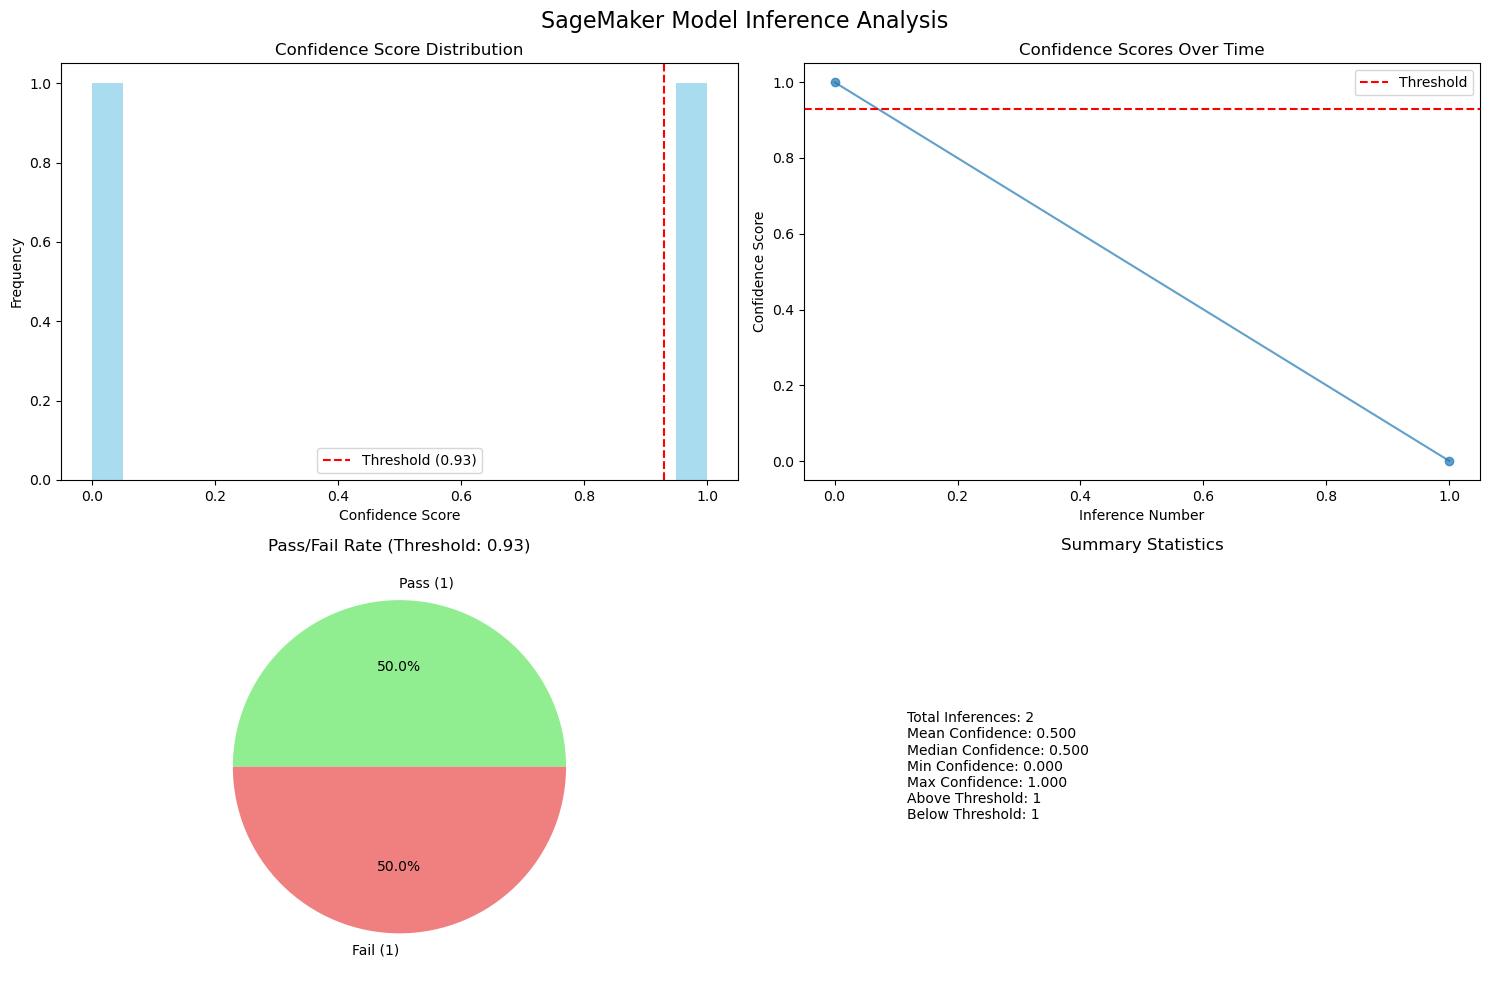


=== Sample Inference Record ===
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "image/png",
      "mode": "INPUT",
      "data": "iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAACptJREFUeJxNl+lvXEd2R09t7/V7vTfJJqnmpoWkLFmybMuDxMgMJoPkz46DIEBmkRWPd8m2Fspcm93shf36rVWVD1SMuR8LhULhh3svzhGfPLzrS0JWN7c4Pz+lSDOyskJIhbMVEvACtFR0V7p0Gz1kvUWju0ael2RljgkClJIIm1NZ8FLjqooyL9DGEEQ1lNJkWYH3HgFY55DOI4NajApqOKnJvaaQNUonUEpRb7bwKqB0grjZobPaJ+50aTXaWJuTLGc47wBw1lGVFZ1OB6U03nuklCAEzWaTZrP525nnpgQCOVqUWKlpbh/Q6K7S7G/ilbq56D1aK+r1Bp///g/IKEZEDYJGg+H5KXmWooTEW0eRZUit0FqihCOqhcRxjDEGIQTOWYTwOFehJQRa4QTo1b19kvmYdn+DHWOx1jM6PUIIQZ7naK3Z2Rtw8PAOr179wCIrqTzkWUZUbyIRKCFAaaKoxnQ6YXV1DSUNQigmsxlSSpbLJd478GDLEqkUSNCdzXUmV2ccvfiGlcE6jWYdKQRSSpRStFotqrJiMhyy0uogTMxiuSA0CiElCPDeo5QkSRKcs1xcXFDkFc4JwijEekdZliilwHustThrEVKjhUvwNmM6uiAMDL7tcN7jpaQRN5BKY0vLclbSWhtgoib73ZifX71mNkv

In [43]:
from sagemaker.s3 import S3Downloader
import boto3
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# Your bucket name
bucket_name = "sagemaker-us-east-1-761018893391"

# Step 1: Find your data capture paths
def find_data_capture_paths():
    """Find available data capture paths in your S3 bucket"""
    s3 = boto3.client('s3')
    
    print("=== Looking for Data Capture Paths ===")
    
    # Common data capture prefixes
    prefixes_to_check = [
        "data_capture/",
        f"{bucket_name}/data_capture/",
        "sagemaker-model-monitor/",
        "datacapture/"
    ]
    
    found_paths = []
    
    for prefix in prefixes_to_check:
        try:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, MaxKeys=10)
            if 'Contents' in response:
                print(f"\n✓ Found data in: s3://{bucket_name}/{prefix}")
                for obj in response['Contents'][:5]:  # Show first 5 files
                    print(f"  - {obj['Key']}")
                    found_paths.append(f"s3://{bucket_name}/{obj['Key']}")
        except Exception as e:
            continue
    
    # Also check for endpoint-specific capture data
    try:
        # Look for any capture data
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix="", MaxKeys=100)
        if 'Contents' in response:
            capture_files = [obj['Key'] for obj in response['Contents'] 
                           if 'capture' in obj['Key'].lower() or 'datacapture' in obj['Key'].lower()]
            if capture_files:
                print(f"\n✓ Found capture-related files:")
                for file in capture_files[:10]:
                    print(f"  - s3://{bucket_name}/{file}")
                    found_paths.append(f"s3://{bucket_name}/{file}")
    except Exception as e:
        print(f"Error searching for capture files: {e}")
    
    return found_paths

# Step 2: Download and process the data
def download_and_process_data(data_path):
    """Download and process captured inference data"""
    try:
        print(f"\nDownloading data from: {data_path}")
        S3Downloader.download(data_path, "captured_data")
        
        # Process downloaded files
        inference_records = []
        
        for root, dirs, files in os.walk("captured_data"):
            for file in files:
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'r') as f:
                        # Handle JSONLines format
                        for line in f:
                            if line.strip():
                                record = json.loads(line)
                                inference_records.append(record)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
        
        return inference_records
        
    except Exception as e:
        print(f"Error downloading data: {e}")
        return []

# Step 3: Visualize the data
def visualize_inference_data(inference_records):
    """Create visualizations of the inference data"""
    if not inference_records:
        print("No inference records to visualize")
        return
    
    print(f"\nProcessing {len(inference_records)} inference records...")
    
    # Extract data for visualization
    timestamps = []
    predictions = []
    confidence_scores = []
    
    for record in inference_records:
        try:
            # Extract timestamp
            if 'eventMetadata' in record:
                timestamp = record['eventMetadata'].get('inferenceTime', '')
                timestamps.append(timestamp)
            
            # Extract predictions (format may vary)
            if 'captureData' in record:
                capture_data = record['captureData']
                if 'endpointOutput' in capture_data:
                    output = capture_data['endpointOutput']['data']
                    # Parse the prediction output
                    try:
                        pred_data = json.loads(output)
                        if isinstance(pred_data, list):
                            confidence_scores.extend(pred_data)
                        elif isinstance(pred_data, dict):
                            confidence_scores.extend(pred_data.values())
                    except:
                        # Handle different output formats
                        confidence_scores.append(float(output) if output.replace('.','').isdigit() else 0)
        except Exception as e:
            continue
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('SageMaker Model Inference Analysis', fontsize=16)
    
    # 1. Confidence Score Distribution
    if confidence_scores:
        axes[0,0].hist(confidence_scores, bins=20, alpha=0.7, color='skyblue')
        axes[0,0].axvline(x=0.93, color='red', linestyle='--', label='Threshold (0.93)')
        axes[0,0].set_title('Confidence Score Distribution')
        axes[0,0].set_xlabel('Confidence Score')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].legend()
    
    # 2. Inferences over time
    if timestamps and confidence_scores:
        axes[0,1].plot(range(len(confidence_scores)), confidence_scores, 'o-', alpha=0.7)
        axes[0,1].axhline(y=0.93, color='red', linestyle='--', label='Threshold')
        axes[0,1].set_title('Confidence Scores Over Time')
        axes[0,1].set_xlabel('Inference Number')
        axes[0,1].set_ylabel('Confidence Score')
        axes[0,1].legend()
    
    # 3. Pass/Fail Analysis
    if confidence_scores:
        pass_count = sum(1 for score in confidence_scores if score >= 0.93)
        fail_count = len(confidence_scores) - pass_count
        
        axes[1,0].pie([pass_count, fail_count], 
                     labels=[f'Pass ({pass_count})', f'Fail ({fail_count})'],
                     colors=['lightgreen', 'lightcoral'],
                     autopct='%1.1f%%')
        axes[1,0].set_title('Pass/Fail Rate (Threshold: 0.93)')
    
    # 4. Summary Statistics
    if confidence_scores:
        stats_text = f"""
        Total Inferences: {len(confidence_scores)}
        Mean Confidence: {np.mean(confidence_scores):.3f}
        Median Confidence: {np.median(confidence_scores):.3f}
        Min Confidence: {min(confidence_scores):.3f}
        Max Confidence: {max(confidence_scores):.3f}
        Above Threshold: {sum(1 for s in confidence_scores if s >= 0.93)}
        Below Threshold: {sum(1 for s in confidence_scores if s < 0.93)}
        """
        axes[1,1].text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center')
        axes[1,1].set_title('Summary Statistics')
        axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return confidence_scores

# Main execution
print("=== Step Function Data Analysis ===")

# First, find your data capture paths
data_paths = find_data_capture_paths()

if not data_paths:
    print("\n❌ No data capture paths found. Make sure:")
    print("1. You've run several Step Function executions")
    print("2. Data capture is enabled on your SageMaker endpoint")
    print("3. The executions completed successfully")
else:
    print(f"\n✅ Found {len(data_paths)} data paths")
    
    # TODO: Choose a specific path from the ones found above
    # Replace this with one of the paths printed above
    data_path = data_paths[0] if data_paths else "s3://your-bucket/data_capture/yyyy/mm/dd/hh/"
    
    print(f"\nUsing data path: {data_path}")
    
    # Download and process the data
    inference_records = download_and_process_data(data_path)
    
    if inference_records:
        print(f"\n✅ Successfully loaded {len(inference_records)} inference records")
        
        # Visualize the data
        import numpy as np
        confidence_scores = visualize_inference_data(inference_records)
        
        # Print sample records for debugging
        print("\n=== Sample Inference Record ===")
        if inference_records:
            print(json.dumps(inference_records[0], indent=2))
    else:
        print("\n❌ No inference records found or processed")

# Alternative: Manual path specification
print("\n" + "="*60)
print("MANUAL PATH SPECIFICATION:")
print("If the automatic detection didn't work, manually set:")
print('data_path = "s3://sagemaker-us-east-1-761018893391/your-specific-capture-path/"')
print("where 'your-specific-capture-path' might look like:")
print("- data_capture/2025/06/12/14/")
print("- sagemaker-model-monitor/endpoint-name/2025/06/12/")
print("- datacapture/AllTraffic/2025/06/12/14/")

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [44]:
!pip install jsonlines
import jsonlines

  Using cached jsonlines-4.0.0-py3-none-any.whl.metadata (1.6 kB)
Using cached jsonlines-4.0.0-py3-none-any.whl (8.7 kB)


Now we can extract the data from each of the source files:

In [45]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from collections import Counter

In [46]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")
print(f"Found {len(file_handles)} files: {file_handles}")
# Dump all the data into an array
json_data = []
# for jsonl in file_handles:
#     with jsonlines.open(f"./captured_data/{jsonl}") as f:
#         json_data.append(f.read())
for jsonl in file_handles:
    print(f"Processing {jsonl}...")
    try:
        with jsonlines.open(f"./captured_data/{jsonl}") as f:
            json_data.append(f.read())
    except Exception as e:
        print(f"Error processing {jsonl}: {e}")

print(f"Loaded {len(json_data)} inference records")

Found 1 files: ['59-24-071-3ff060df-0321-43bb-af86-cef7e755569d.jsonl']
Processing 59-24-071-3ff060df-0321-43bb-af86-cef7e755569d.jsonl...
Loaded 1 inference records


The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [47]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.999500036239624, 0.0004999368684366345], '2025-06-12T09:59:24Z')

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

In [48]:
# Test the getter function
if json_data:
    sample_inference, sample_timestamp = simple_getter(json_data[0])
    print(f"\nSample data:")
    print(f"  Inference: {sample_inference}")
    print(f"  Timestamp: {sample_timestamp}")


Sample data:
  Inference: [0.999500036239624, 0.0004999368684366345]
  Timestamp: 2025-06-12T09:59:24Z


In [49]:
timestamps = []
max_confidences = []
all_confidences = []
inference_counts = []

for obj in json_data:
    try:
        inference, timestamp = simple_getter(obj)
        
        # Store timestamp
        timestamps.append(timestamp)
        
        # Handle different inference formats
        if isinstance(inference, list):
            confidences = [float(x) for x in inference]
            max_confidences.append(max(confidences))
            all_confidences.extend(confidences)
            inference_counts.append(len(confidences))
        elif isinstance(inference, dict):
            confidences = [float(x) for x in inference.values()]
            max_confidences.append(max(confidences))
            all_confidences.extend(confidences)
            inference_counts.append(len(confidences))
        else:
            # Single value
            conf = float(inference)
            max_confidences.append(conf)
            all_confidences.append(conf)
            inference_counts.append(1)
            
    except Exception as e:
        print(f"Error processing record: {e}")
        continue

print(f"Processed {len(max_confidences)} inference records")
print(f"Total individual predictions: {len(all_confidences)}")

Processed 1 inference records
Total individual predictions: 2


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(array([19539., 19723., 19905., 20089., 20270., 20454., 20635., 20819.,
        21000.]),
 [Text(19539.0, 0, '2023-07'),
  Text(19723.0, 0, '2024-01'),
  Text(19905.0, 0, '2024-07'),
  Text(20089.0, 0, '2025-01'),
  Text(20270.0, 0, '2025-07'),
  Text(20454.0, 0, '2026-01'),
  Text(20635.0, 0, '2026-07'),
  Text(20819.0, 0, '2027-01'),
  Text(21000.0, 0, '2027-07')])

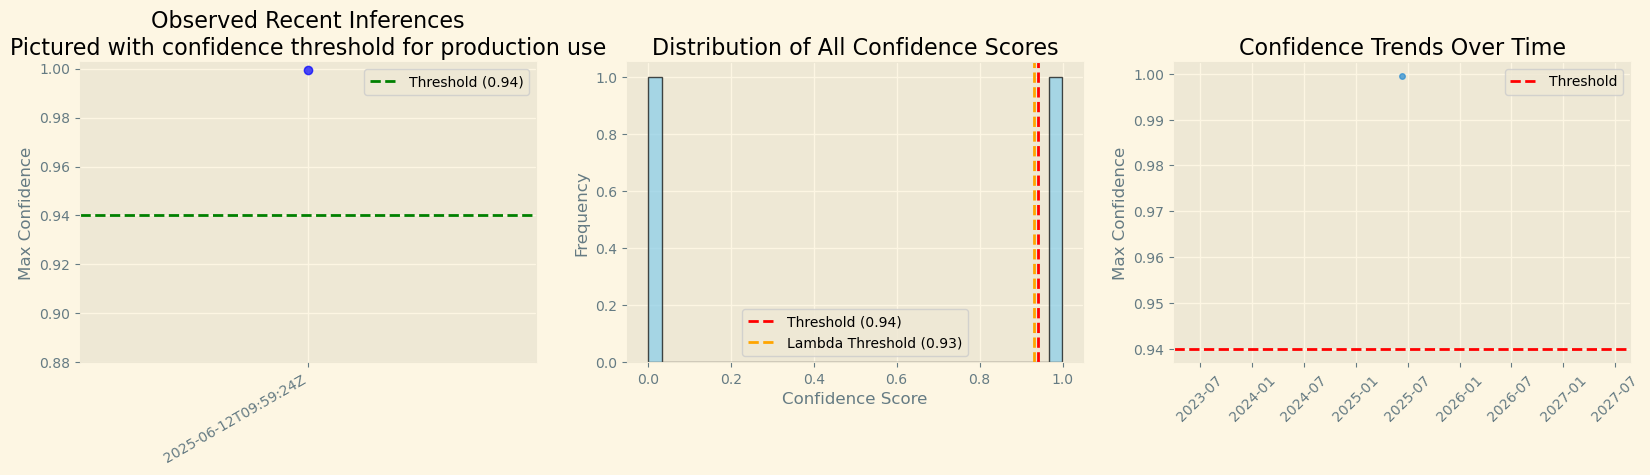

In [50]:
# Set up the plotting style
plt.style.use("Solarize_Light2")
fig = plt.figure(figsize=(20, 15))

# Visualization 1: Original scatter plot (your example)
plt.subplot(3, 3, 1)
x = timestamps
y = max_confidences
plt.scatter(x, y, c=['r' if k < 0.94 else 'b' for k in y], alpha=0.7)
plt.axhline(y=0.94, color='g', linestyle='--', label='Threshold (0.94)')
plt.ylim(bottom=0.88)
plt.ylabel("Max Confidence")
plt.title("Observed Recent Inferences\nPictured with confidence threshold for production use")
plt.gcf().autofmt_xdate()
plt.legend()

# Visualization 2: Confidence Distribution Histogram
plt.subplot(3, 3, 2)
plt.hist(all_confidences, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0.94, color='red', linestyle='--', linewidth=2, label='Threshold (0.94)')
plt.axvline(x=0.93, color='orange', linestyle='--', linewidth=2, label='Lambda Threshold (0.93)')
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of All Confidence Scores")
plt.legend()

# Visualization 3: Time Series Line Plot
plt.subplot(3, 3, 3)
if timestamps:
    # Convert timestamps to datetime for better plotting
    try:
        dt_timestamps = [datetime.fromisoformat(ts.replace('Z', '+00:00')) for ts in timestamps]
        plt.plot(dt_timestamps, max_confidences, 'o-', alpha=0.7, markersize=4)
    except:
        plt.plot(range(len(max_confidences)), max_confidences, 'o-', alpha=0.7, markersize=4)
plt.axhline(y=0.94, color='red', linestyle='--', label='Threshold')
plt.ylabel("Max Confidence")
plt.title("Confidence Trends Over Time")
plt.legend()
plt.xticks(rotation=45)

In [51]:
# # Populate the data for the x and y axis
# x = []
# y = []
# for obj in json_data:
#     inference, timestamp = simple_getter(obj)
    
#     y.append(max(inference))
#     x.append(timestamp)

# # Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# # Plot the data
# plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
# plt.axhline(y=0.94, color='g', linestyle='--')
# plt.ylim(bottom=.88)

# # Add labels
# plt.ylabel("Confidence")
# plt.suptitle("Observed Recent Inferences", size=14)
# plt.title("Pictured with confidence threshold for production use", size=10)

# # Give it some pizzaz!
# plt.style.use("Solarize_Light2")
# plt.gcf().autofmt_xdate()

### Todo: build your own visualization


Text(0.5, 1.0, 'Performance Summary')

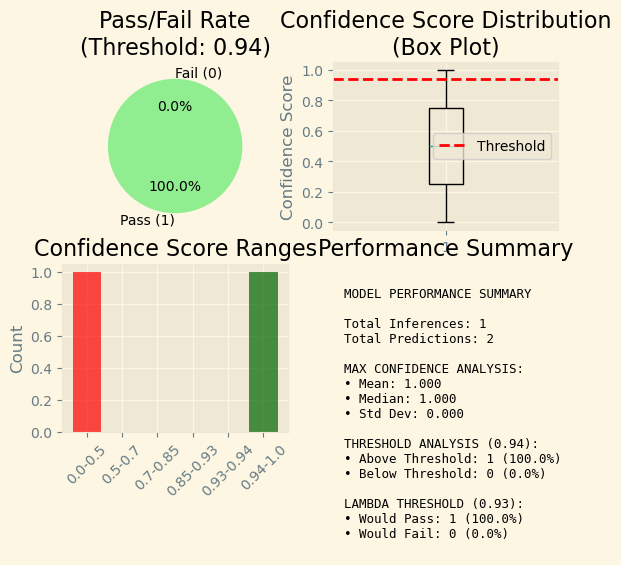

In [52]:
# Visualization 4: Pass/Fail Analysis
plt.subplot(2, 2, 1)
pass_count = sum(1 for conf in max_confidences if conf >= 0.94)
fail_count = len(max_confidences) - pass_count
plt.pie([pass_count, fail_count], 
        labels=[f'Pass ({pass_count})', f'Fail ({fail_count})'],
        colors=['lightgreen', 'lightcoral'],
        autopct='%1.1f%%',
        startangle=90)
plt.title("Pass/Fail Rate\n(Threshold: 0.94)")

# Visualization 5: Box Plot of Confidences
plt.subplot(2, 2, 2)
plt.boxplot(all_confidences, vert=True)
plt.axhline(y=0.94, color='red', linestyle='--', label='Threshold')
plt.ylabel("Confidence Score")
plt.title("Confidence Score Distribution\n(Box Plot)")
plt.legend()

# Visualization 6: Confidence Ranges Analysis
plt.subplot(2, 2, 3)
ranges = ['0.0-0.5', '0.5-0.7', '0.7-0.85', '0.85-0.93', '0.93-0.94', '0.94-1.0']
range_counts = [
    sum(1 for c in all_confidences if 0.0 <= c < 0.5),
    sum(1 for c in all_confidences if 0.5 <= c < 0.7),
    sum(1 for c in all_confidences if 0.7 <= c < 0.85),
    sum(1 for c in all_confidences if 0.85 <= c < 0.93),
    sum(1 for c in all_confidences if 0.93 <= c < 0.94),
    sum(1 for c in all_confidences if 0.94 <= c <= 1.0)
]
colors = ['red', 'orange', 'yellow', 'lightblue', 'lightgreen', 'darkgreen']
plt.bar(ranges, range_counts, color=colors, alpha=0.7)
plt.ylabel("Count")
plt.title("Confidence Score Ranges")
plt.xticks(rotation=45)

# Visualization 7: Model Performance Metrics
plt.subplot(2,2, 4)
metrics_text = f"""
MODEL PERFORMANCE SUMMARY

Total Inferences: {len(max_confidences)}
Total Predictions: {len(all_confidences)}

MAX CONFIDENCE ANALYSIS:
• Mean: {np.mean(max_confidences):.3f}
• Median: {np.median(max_confidences):.3f}
• Std Dev: {np.std(max_confidences):.3f}

THRESHOLD ANALYSIS (0.94):
• Above Threshold: {sum(1 for c in max_confidences if c >= 0.94)} ({100*sum(1 for c in max_confidences if c >= 0.94)/len(max_confidences):.1f}%)
• Below Threshold: {sum(1 for c in max_confidences if c < 0.94)} ({100*sum(1 for c in max_confidences if c < 0.94)/len(max_confidences):.1f}%)

LAMBDA THRESHOLD (0.93):
• Would Pass: {sum(1 for c in max_confidences if c >= 0.93)} ({100*sum(1 for c in max_confidences if c >= 0.93)/len(max_confidences):.1f}%)
• Would Fail: {sum(1 for c in max_confidences if c < 0.93)} ({100*sum(1 for c in max_confidences if c < 0.93)/len(max_confidences):.1f}%)
"""
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontfamily='monospace', fontsize=9)
plt.axis('off')
plt.title("Performance Summary")

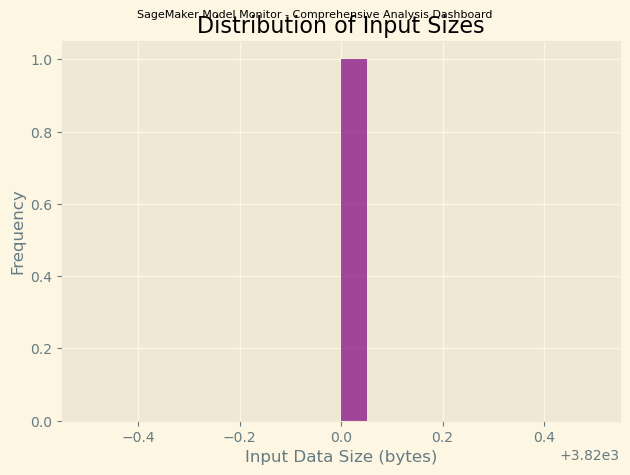

In [53]:
# Visualization 9: Input Image Analysis (if available)
plt.subplot(1, 1,1)
try:
    # Try to extract input data information
    input_sizes = []
    for obj in json_data:
        try:
            input_data = obj["captureData"]["endpointInput"]["data"]
            input_sizes.append(len(input_data))
        except:
            continue
    
    if input_sizes:
        plt.hist(input_sizes, bins=20, alpha=0.7, color='purple')
        plt.xlabel("Input Data Size (bytes)")
        plt.ylabel("Frequency")
        plt.title("Distribution of Input Sizes")
    else:
        plt.text(0.5, 0.5, "Input size data\nnot available", 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title("Input Data Analysis")
        plt.axis('off')
except:
    plt.text(0.5, 0.5, "Input analysis\nfailed", 
            ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("Input Data Analysis")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("SageMaker Model Monitor - Comprehensive Analysis Dashboard", 
             fontsize=8, y=0.98)
plt.show()


In [54]:

print("\n=== DETAILED ANALYSIS RESULTS ===")
print(f"📊 INFERENCE SUMMARY:")
print(f"   • Total inference requests: {len(max_confidences)}")
print(f"   • Total individual predictions: {len(all_confidences)}")
print(f"   • Average predictions per request: {np.mean(inference_counts):.1f}")

print(f"\n🎯 CONFIDENCE ANALYSIS:")
print(f"   • Highest confidence: {max(all_confidences):.3f}")
print(f"   • Lowest confidence: {min(all_confidences):.3f}")
print(f"   • Mean confidence: {np.mean(all_confidences):.3f}")
print(f"   • Median confidence: {np.median(all_confidences):.3f}")

print(f"\n⚡ THRESHOLD PERFORMANCE:")
lambda_pass = sum(1 for c in max_confidences if c >= 0.93)
lambda_fail = len(max_confidences) - lambda_pass
print(f"   • Lambda threshold (0.93): {lambda_pass} pass, {lambda_fail} fail ({100*lambda_pass/len(max_confidences):.1f}% pass rate)")

analysis_pass = sum(1 for c in max_confidences if c >= 0.94)
analysis_fail = len(max_confidences) - analysis_pass
print(f"   • Analysis threshold (0.94): {analysis_pass} pass, {analysis_fail} fail ({100*analysis_pass/len(max_confidences):.1f}% pass rate)")

print(f"\n✅ WORKFLOW VALIDATION:")
if lambda_pass > 0:
    print(f"   • Step Function should PASS {lambda_pass} executions")
if lambda_fail > 0:
    print(f"   • Step Function should FAIL {lambda_fail} executions")

print(f"\n📈 RECOMMENDATIONS:")
if lambda_pass/len(max_confidences) < 0.5:
    print("   • Consider lowering the confidence threshold - many predictions are being rejected")
elif lambda_pass/len(max_confidences) > 0.9:
    print("   • Consider raising the confidence threshold - almost all predictions are passing")
else:
    print("   • Current threshold (0.93) appears well-calibrated")


=== DETAILED ANALYSIS RESULTS ===
📊 INFERENCE SUMMARY:
   • Total inference requests: 1
   • Total individual predictions: 2
   • Average predictions per request: 2.0

🎯 CONFIDENCE ANALYSIS:
   • Highest confidence: 1.000
   • Lowest confidence: 0.000
   • Mean confidence: 0.500
   • Median confidence: 0.500

⚡ THRESHOLD PERFORMANCE:
   • Lambda threshold (0.93): 1 pass, 0 fail (100.0% pass rate)
   • Analysis threshold (0.94): 1 pass, 0 fail (100.0% pass rate)

✅ WORKFLOW VALIDATION:
   • Step Function should PASS 1 executions

📈 RECOMMENDATIONS:
   • Consider raising the confidence threshold - almost all predictions are passing


### Congratulations!

You've reached the end of the project. In this project you created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. You used the SageMaker Estimator API to deploy your SageMaker Model and Endpoint, and you used AWS Lambda and Step Functions to orchestrate your ML workflow. Using SageMaker Model Monitor, you instrumented and observed your Endpoint, and at the end of the project you built a visualization to help stakeholders understand the performance of the Endpoint over time. If you're up for it, you can even go further with these stretch goals:

* Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.
* Modify your event driven workflow: can you rewrite your Lambda functions so that the workflow can process multiple image inputs in parallel? Can the Step Function "fan out" to accomodate this new workflow?
* Consider the test data generator we provided for you. Can we use it to create a "dummy data" generator, to simulate a continuous stream of input data? Or a big paralell load of data?
* What if we want to get notified every time our step function errors out? Can we use the Step Functions visual editor in conjunction with a service like SNS to accomplish this? Try it out!


